### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [2]:
# from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
import matplotlib.pyplot as plt
import gc
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists
import dask_labextension
from pathlib import Path
import numpy as np
import dask
from multipledispatch import dispatch
from scipy import stats
import pickle
sns.set_context("talk")

In [3]:
from multipledispatch import dispatch
@dispatch(object, object)
def prepare_IVTE_and_IVTN(DJF_phases, phase):
    IVT = xr.merge([DJF_phases["IVTE"][phase], DJF_phases["IVTN"][phase]])
    IVT = IVT.isel(longitude = slice(0, None, 8), latitude =  slice(0, None, 8))
    IVT["IVT"] = np.sqrt(IVT["IVTE"]**2 + IVT["IVTN"]**2)
    IVT["IVT"].attrs["units"] = "(kg m)/s "
    return IVT 
def prepare_IVTE_and_IVTN_hires(DJF_phases, phase):
    IVT = xr.merge([DJF_phases["IVTE"][phase], DJF_phases["IVTN"][phase]])
    IVT["IVT"] = np.sqrt(IVT["IVTE"]**2 + IVT["IVTN"]**2)
    IVT["IVT"].attrs["units"] = "kg /m /s "
    return IVT 

@dispatch(object)
def prepare_IVTE_and_IVTN(DJF_phase):
    IVT = xr.merge([DJF_phase["IVTE"], DJF_phase["IVTN"]]).sel(latitude = slice(50,  -2)).sel(longitude = slice(-140, -80))
    IVT = IVT.isel(longitude = slice(0, None, 4), latitude =  slice(0, None, 4))
    IVT["IVT"] = np.sqrt(IVT["IVTE"]**2 + IVT["IVTN"]**2)
    IVT["IVT"].attrs["units"] = "(kg m)/s "
    return IVT 

In [6]:
def combine_phases(var_phases, phases_dict):
    d = dict()
    d["18"] = xr.merge([var_phases["1"], var_phases["8"]]).compute()
    d["23"] = xr.merge([var_phases["2"], var_phases["3"]]).compute()
    d["45"] = xr.merge([var_phases["4"], var_phases["5"]]).compute()
    d["67"] = xr.merge([var_phases["6"], var_phases["7"]]).compute()
    
    return d
# combine_DJF_phases = dict()
# for key in DJF_phases.keys():
#     print(key)
#     combine_DJF_phases[key]= combine_phases(DJF_phases[key], phases_dict)
#     for phase, phase_indices in phases_dict.items(): 
#         DJF_phases[key][phase] = DJF_phases[key][phase].compute()

In [7]:

def xr_ttest_twoside(ds, axis = "time", conf_lev = 0.95):
    beta = 1 - 0.95
    timeax = ds.get_axis_num(axis)

    temp = stats.ttest_1samp(ds.values, popmean=0.0, axis = timeax, nan_policy = "propagate").pvalue
    temp[temp < beta] = np.nan
    temp[temp > beta] = 1.0
    new_ds = ds.isel({axis:0}).drop(axis)
    new_ds.values = temp
    return new_ds
def xr_ttest(ds, axis = "time", conf_lev = 0.95):
    beta = 1 - 0.96
    timeax = ds.get_axis_num(axis)
    crit_t = abs(stats.t.ppf(q=beta,df=len(ds[axis])))
    temp = stats.ttest_1samp(ds.values, popmean=0.0, axis = timeax, nan_policy = "propagate").statistic
    temp[np.abs(temp) < crit_t] = np.nan
    temp[np.abs(temp) >= crit_t] = 1.0
    new_ds = ds.isel({axis:0}).drop(axis)
    new_ds.values = temp
    return new_ds
        

### We read in the Amaya Coastal Wave Index Amplitude $(\text{Index} =  \sqrt{\text{PC1}^2 + \text{PC2}^2)}$ and Phase $(\text{Phase} = atan( {\frac{\text{PC2}}{\text{PC1}}}))$ and recompute $\text{PC1}$ and $\text{PC2}$. We also remove the leap-year days from the GLORYS dataset.

In [12]:
INDEX_TYPE = "SM"
indexdir = INDEX_TYPE + "_Phases"
with open(GLORYS_data_dir(INDEX_TYPE + "_Phases/Composites.pickle"), 'rb') as handle:
    DJF_phases_SM = pickle.load(handle)

INDEX_TYPE = "S"
indexdir = INDEX_TYPE + "_Phases"
with open(GLORYS_data_dir(INDEX_TYPE + "_Phases/Composites.pickle"), 'rb') as handle:
    DJF_phases_S = pickle.load(handle)
# # Store data (serialize)
# with open(GLORYS_data_dir(INDEX_TYPE + "_Phases/CompositesPhase4.pickle"), 'rb') as handle:
#     DJF_phase4_dict = pickle.load(handle)
# Store data (serialize)
# with open(GLORYS_data_dir(INDEX_TYPE + "_Phases/IndexPhases.pickle"), 'rb') as handle:
#     phases_dict = pickle.load(handle)

In [14]:
labels_dict = {"SM" : "SSH/SST CTW Index", "S" : "SSH CTW Index", "RMM" : "RMM Index"}

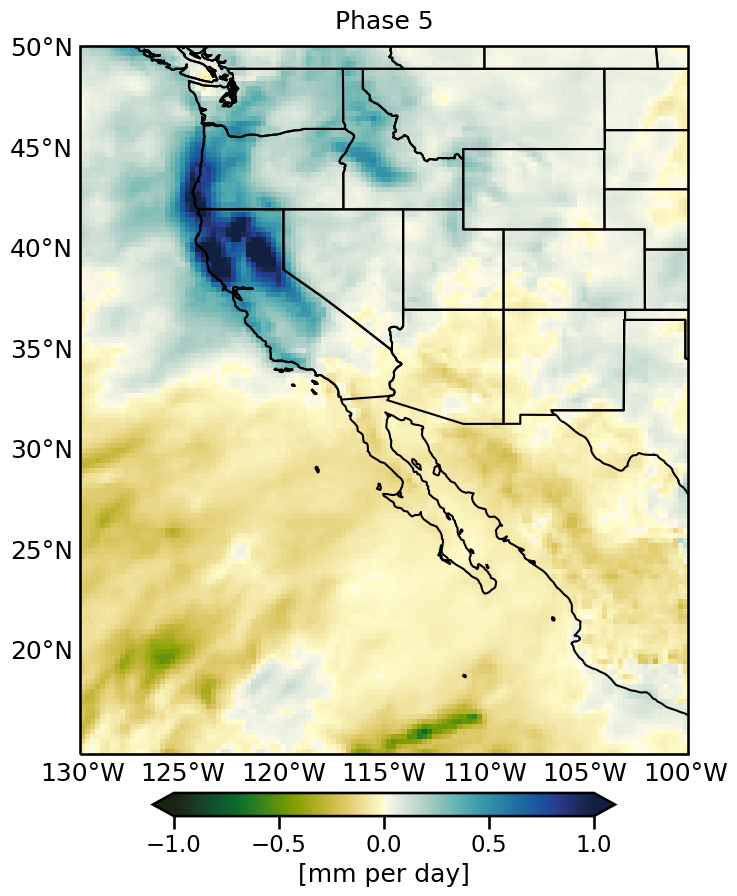

In [57]:
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-0.4, 0.41, 0.1) 

phase = "5"
phase_num = int(phase) - 1; i = phase_num
ax.add_feature(cfeature.STATES) 
var = DJF_phases_SM["Precip"][phase].mean("time") - DJF_phases_S["Precip"][phase].mean("time")
var.sel(latitude = slice(50,  15)).sel(longitude = slice(-130, -100)).plot(ax = ax, cmap = cm.delta_r,transform = ccrs.PlateCarree(),
                                                                                      vmin = -1, vmax = 1, add_colorbar = True,zorder=0, 
                                                                                       cbar_kwargs = {"label":"[mm per day]", "extend": "both", 
                                                                                                      "orientation":"horizontal", "ax":ax,
                                                                                                     "fraction":0.03, "pad":0.05})

# statistics = xr_ttest(DJF_phases["Precip"][phase]).sel(latitude = slice(50,  15)).sel(longitude = slice(-130, -100))
# LONS, LATS = np.meshgrid(statistics.longitude.values, statistics.latitude.values)
# ax.scatter((LONS * statistics.values), (LATS * statistics.values), transform = ccrs.PlateCarree(), s = 0.07, marker = "x", alpha = 0.5, c = "k")

ax.set_title("Phase " + str(phase_num+1), fontsize = 18)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
fig.savefig(plotsdir("generals/Difference_Index_Phase5_Precip_CompositesDJFM.png"), bbox_inches = "tight")
# fig

phase


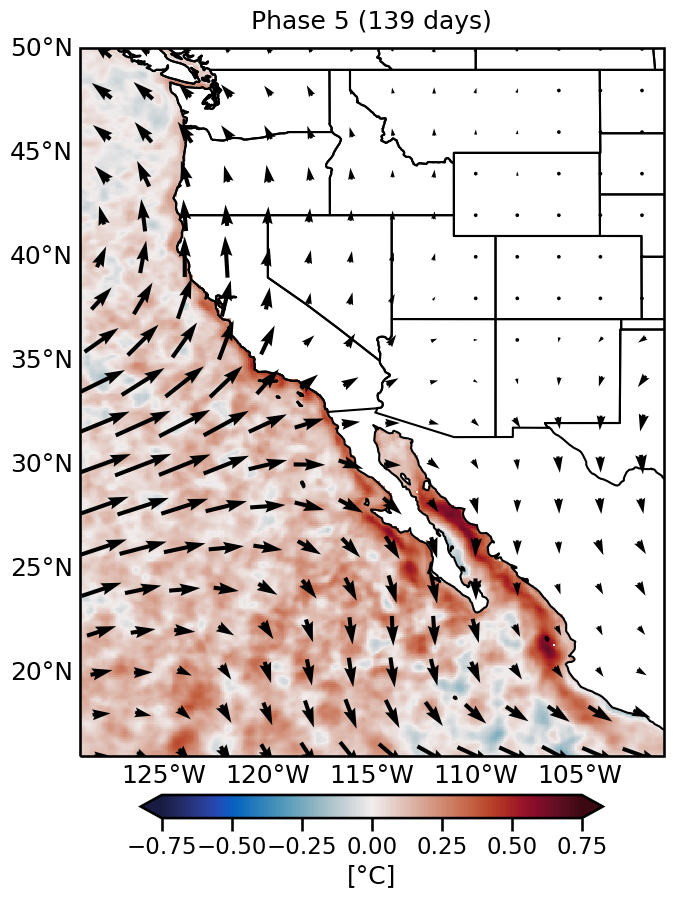

In [204]:
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-50, 51, 10) 
# fig.tight_layout()

phase = "5"
phase_indices = phases_dict[phase]
phase_num = int(phase) - 1; i = phase_num
ax.add_feature(cfeature.STATES) 
IVT = prepare_IVTE_and_IVTN(DJF_phases, phase).sel(latitude = slice(50,  16)).sel(longitude = slice(-129, -101))
var = DJF_phases["SST"][phase].sel(latitude = slice(16, 50), longitude = slice(-129, -101))
print("phase")

IVT.mean("time").plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", width = 0.007)

var.mean("time").plot.pcolormesh(ax = ax, cmap = cm.balance,transform = ccrs.PlateCarree(), 
                                                                                      vmin = -0.75, vmax = 0.75, add_colorbar = True,zorder=0,
                                                                                       cbar_kwargs = {"label":"[°C]", "extend": "both", 
                                                                                                      "orientation":"horizontal", "ax":ax,
                                                                                                     "fraction":0.03, "pad":0.05})
        
ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 18)
        # ax.clabel(cs, inline=True, fontsize=10)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
          linewidth=1, color='gray', alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()

fig.savefig(plotsdir("generals/" + INDEX_TYPE + "_Index_Phase5_SST_IVT_CompositesDJF.png"), bbox_inches = "tight")

phase


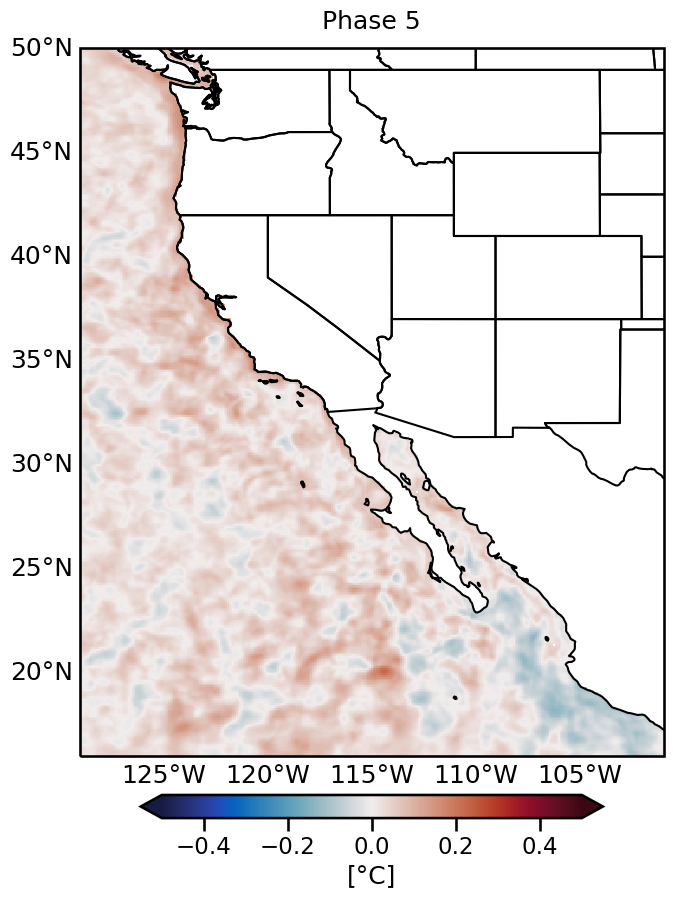

In [27]:
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
z500_levels = np.arange(-50, 51, 10) 
# fig.tight_layout()

phase = "5"
phase_indices = phases_dict[phase]
phase_num = int(phase) - 1; i = phase_num
ax.add_feature(cfeature.STATES) 
IVT = prepare_IVTE_and_IVTN(DJF_phases, phase).sel(latitude = slice(50,  16)).sel(longitude = slice(-129, -101))
print("phase")
var = DJF_phases_SM["SST"][phase].mean("time") - DJF_phases_S["SST"][phase].mean("time")
var = var.sel(latitude = slice(16, 50), longitude = slice(-129, -101))
var.plot.pcolormesh(ax = ax, cmap = cm.balance,transform = ccrs.PlateCarree(), 
                                                                                      vmin = -0.5, vmax = 0.5, add_colorbar = True,zorder=0,
                                                                                       cbar_kwargs = {"label":"[°C]", "extend": "both", 
                                                                                                      "orientation":"horizontal", "ax":ax,
                                                                                                     "fraction":0.03, "pad":0.05})
ax.set_title("Phase " + str(phase_num+1), fontsize = 18)
        # ax.clabel(cs, inline=True, fontsize=10)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
          linewidth=1, color='gray', alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
fig.savefig(plotsdir("generals/Difference_Index_Phase5_SST_CompositesDJF.png"), bbox_inches = "tight")

phase


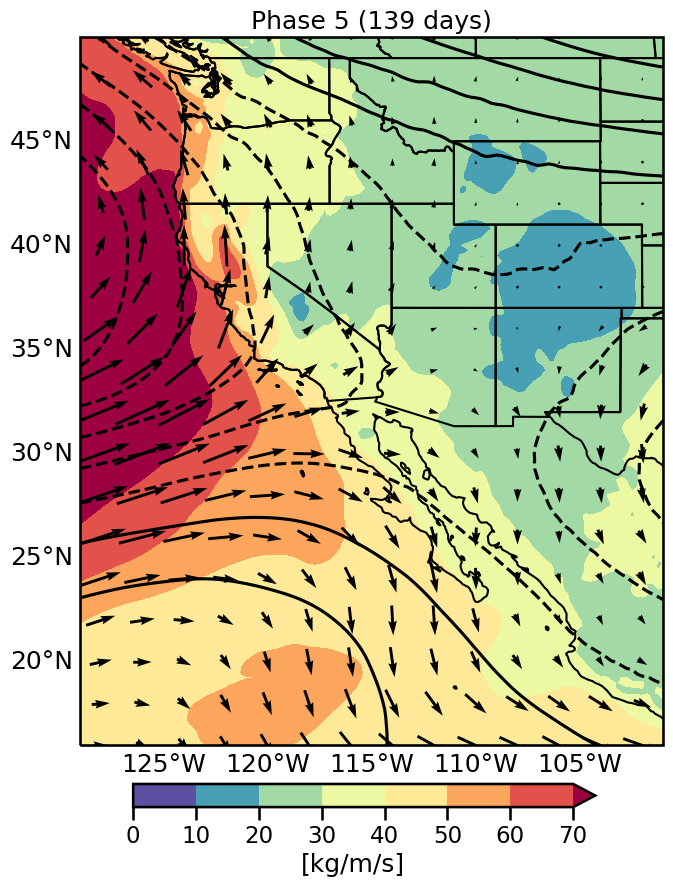

In [31]:
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
levels = np.arange(0, 71, 10)
vmax = levels.max()
z500_levels = np.arange(-50, 61, 5) 

phase = "5"
phase_indices = phases_dict[phase]
phase_num = int(phase) - 1; i = phase_num
ax.add_feature(cfeature.STATES) 
IVT = prepare_IVTE_and_IVTN_hires(DJF_phases, phase).sel(latitude = slice(50,  16)).sel(longitude = slice(-129, -101))
var = IVT.IVT
IVT = prepare_IVTE_and_IVTN(DJF_phases, phase).sel(latitude = slice(50,  16)).sel(longitude = slice(-129, -101))

print("phase")

IVT.mean("time").plot.quiver(ax = ax, x = "longitude", y = "latitude",u = "IVTE", v = "IVTN", width = 0.005)

var.mean("time").plot.contourf(ax = ax, cmap = "Spectral_r",transform = ccrs.PlateCarree(), add_colorbar = True,zorder=0, vmax = vmax, vmin = 0, levels = levels, 
                                                                                       cbar_kwargs = {"label":"[kg/m/s]", "extend": "both", 
                                                                                                      "orientation":"horizontal", "ax":ax,
                                                                                                     "fraction":0.03, "pad":0.05})
        
CS = DJF_phases["z500"][phase].mean("time").sel(latitude = slice(50,  16)).sel(longitude = slice(-129, -101)).plot.contour(ax = ax, colors = "black", levels = z500_levels,
                                                                                                   transform = ccrs.PlateCarree())
ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 18)
        # ax.clabel(cs, inline=True, fontsize=10)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
          linewidth=1, color='gray', alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()

fig.savefig(plotsdir("generals/" + INDEX_TYPE + "_Index_Phase5_IVTVec_CompositesDJF.png"), bbox_inches = "tight")

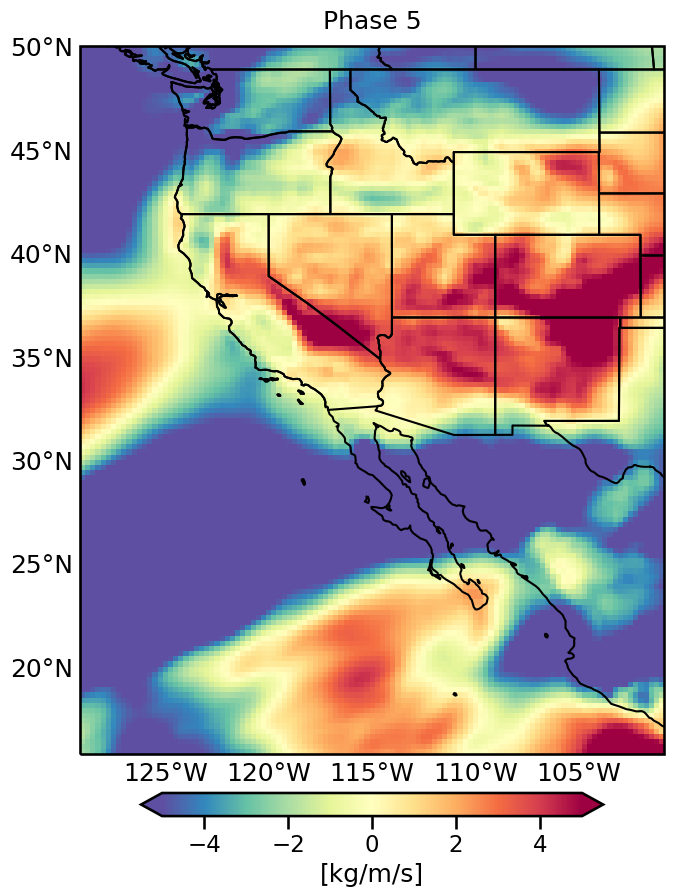

In [56]:
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# fig.tight_layout()
vmax = 5; vmin = -vmax; levels = np.arange(vmin, vmax + .1, 2)
phase = "5"
phase_num = int(phase) - 1; i = phase_num
ax.add_feature(cfeature.STATES) 
IVT = prepare_IVTE_and_IVTN_hires(DJF_phases_SM, phase).sel(latitude = slice(50,  16)).sel(longitude = slice(-129, -101))
IVT_SM = IVT.IVT
IVT = prepare_IVTE_and_IVTN_hires(DJF_phases_S, phase).sel(latitude = slice(50,  16)).sel(longitude = slice(-129, -101))
IVT_S = IVT.IVT
var = 100 * (IVT_SM.mean("time") - IVT_S.mean("time")) / IVT_S.mean("time")

var.plot.pcolormesh(ax = ax, cmap = "Spectral_r",transform = ccrs.PlateCarree(), add_colorbar = True,zorder=0, vmax = vmax, vmin = vmin, 
                                                                                       cbar_kwargs = {"label":"[kg/m/s]", "extend": "both", 
                                                                                                      "orientation":"horizontal", "ax":ax,
                                                                                                     "fraction":0.03, "pad":0.05})
ax.set_title("Phase " + str(phase_num+1), fontsize = 18)
        # ax.clabel(cs, inline=True, fontsize=10)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
          linewidth=1, color='gray', alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()

# fig.savefig(plotsdir("generals/" + INDEX_TYPE + "_Index_Phase5_IVT_CompositesDJF.png"), bbox_inches = "tight")

phase
SM


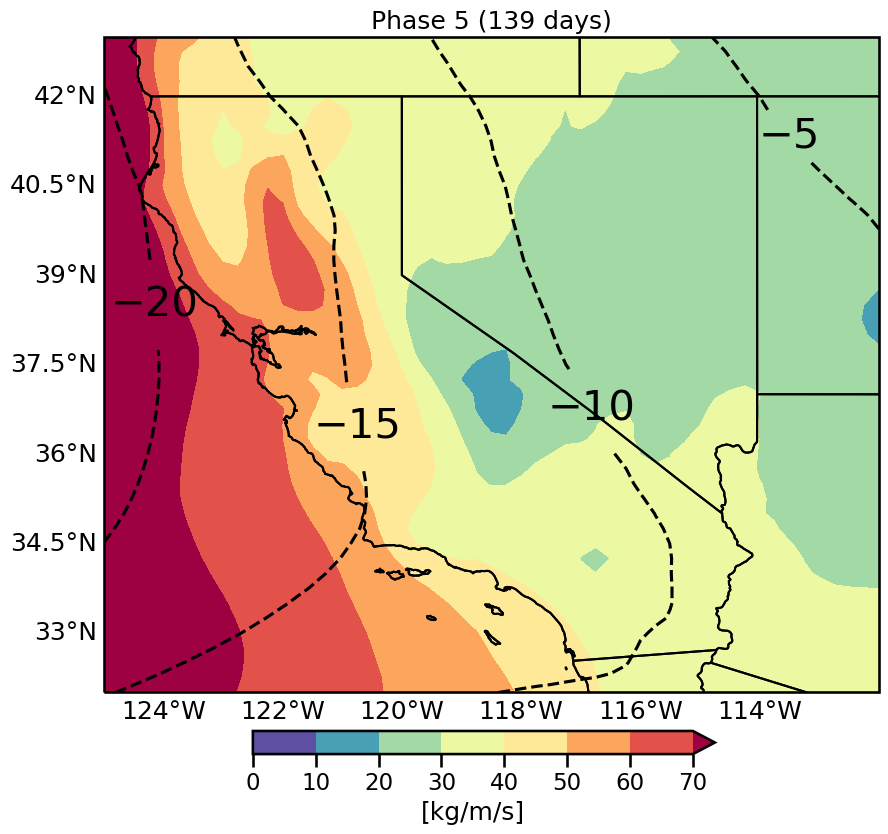

In [208]:
fig, ax = plt.subplots(figsize = (10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# fig.tight_layout()

phase = "5"
phase_indices = phases_dict[phase]
phase_num = int(phase) - 1; i = phase_num
ax.add_feature(cfeature.STATES) 
IVT = prepare_IVTE_and_IVTN_hires(DJF_phases, phase).sel(latitude = slice(43,  32)).sel(longitude = slice(-125, -112))
var = IVT.IVT
IVT = prepare_IVTE_and_IVTN(DJF_phases, phase).sel(latitude = slice(43,  32)).sel(longitude = slice(-125, -112))

print("phase")

var.mean("time").plot.contourf(ax = ax, cmap = "Spectral_r",transform = ccrs.PlateCarree(), add_colorbar = True,zorder=0, vmax = vmax, vmin = 0, levels = levels, 
                                                                                       cbar_kwargs = {"label":"[kg/m/s]", "extend": "both", 
                                                                                                      "orientation":"horizontal", "ax":ax,
                                                                                                     "fraction":0.03, "pad":0.05})
CS = DJF_phases["z500"][phase].mean("time").sel(latitude = slice(43,  32)).sel(longitude = slice(-125, -112)).plot.contour(ax = ax, colors = "black", levels = z500_levels,
                                                                                                   transform = ccrs.PlateCarree())        
ax.set_title("Phase " + str(phase_num+1) + " (" + str(len(phases_dict[str(i+1)])) + " days)", fontsize = 18)
        # ax.clabel(cs, inline=True, fontsize=10)
labels2 = ax.clabel(CS, CS.levels, inline=True, fontsize=30)
for l in labels2:
    l.set_rotation(0)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
          linewidth=1, color='gray', alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
print(INDEX_TYPE)
fig.savefig(plotsdir("generals/" + INDEX_TYPE + "_Index_Phase5_IVT_CaliCompositesDJF.png"), bbox_inches = "tight")